In [2]:
%matplotlib inline

import torch
import os
import shutil
import random 
import torchvision
from torch import nn 
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt 

In [3]:
torch.manual_seed(0)
print ('pytorch version', torch.__version__)

pytorch version 1.10.2


In [4]:
#preparing Training & test sets
#https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
class_names = ['normal','viral','covid']
root_dir = '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset'
source_dirs = ['Normal','Viral Pneumonia','COVID']


if os.path.isdir(os.path.join(root_dir,source_dirs[1])):
    os.mkdir(os.path.join(root_dir,'test'))

    for i,d in enumerate(source_dirs):
        print(os.path.join(root_dir,d))
        print(os.path.join(root_dir,class_names[i]))
        os.rename(os.path.join(root_dir,d),os.path.join(root_dir,class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir,'test',c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir,c)) if x.lower().endswith('png')]
        selected_images = random.sample(images,30)
        for image in selected_images:
            source_path = os.path.join(root_dir,c,image)
            target_path = os.path.join(root_dir,'test',c,image)
            shutil.move(source_path,target_path)
        

In [63]:
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self,image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal','viral','covid']

        for c in class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform

    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name],image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)





In [70]:
#image trasnformations
train_transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(28,28)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Grayscale(num_output_channels=1)
                    #torchvision.transforms.Normalize(mean=[0.485,0.0456,0.406],std=[0.229,0.224,0.225])
                        ])

test_transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(28,28)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Grayscale(num_output_channels=1)
                    #torchvision.transforms.Normalize(mean=[0.485,0.0456,0.406],std=[0.229,0.224,0.225])
                        ])                        

In [71]:
train_dirs = {
'normal': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/normal',
'viral': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/viral',
'covid':'/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/covid'

}

train_dataset = ChestXrayDataset(train_dirs,train_transform)


test_dirs = {
'normal': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/normal',
'viral': '/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/viral',
'covid':'/Users/sureshgorakala/Downloads/COVID-19_Radiography_Dataset/test/covid'

}

test_dataset = ChestXrayDataset(test_dirs,test_transform)

found 10162 normal examples
found 1315 viral examples
found 3586 covid examples
found 30 normal examples
found 30 viral examples
found 30 covid examples


In [72]:
batch_size = 64

dl_train = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)


In [73]:

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 236
Num of test batches 2


In [74]:
for X,y in dl_test:
    print("Shape of X [N, C, H, W] : ", X.shape)
    print("Shape of y : ", y.shape,y.dtype)
    break

Shape of X [N, C, H, W] :  torch.Size([64, 1, 28, 28])
Shape of y :  torch.Size([64]) torch.int64


In [75]:
#data visualization

class_names = train_dataset.class_names

def show_images(images,labels,preds):
    plt.figure(figsize=(8,4))
    for i,image in enumerate(images):
        plt.subplot(1,64,i+1,xticks=[],yticks=[])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485,0.0456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std+mean
        image = np.clip(image,0,1)
        plt.imshow(image)

        col = 'green' if preds[i] ==labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color = col)

    plt.tight_layout()
    plt.show()

    

/var/folders/4f/l13zk5vs4ll_bmjd1d_z78pc0000gn/T/ipykernel_4621/2962085072.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


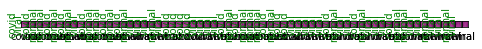

In [76]:
images,labels = next(iter(dl_train))
show_images(images,labels,labels)

/var/folders/4f/l13zk5vs4ll_bmjd1d_z78pc0000gn/T/ipykernel_4621/2962085072.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


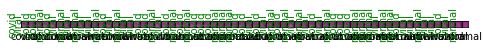

In [77]:
images,labels = next(iter(dl_test))
show_images(images,labels,labels)

In [78]:
#define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,3),
            nn.ReLU()
        )

    def forward(self,X):
        x = self.flatten(X)
        logits = self.linear_relu_stack(x)
        return logits
        


In [79]:
#creating models
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using {} device'.format(device))

using cpu device


In [80]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
    (5): ReLU()
  )
)


In [81]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [82]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X)
        loss  = loss_fn(pred,y)

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss,current = loss.item(),batch *len(X)
            print(f'loss: {loss:>7f}[{current:>5d}/{size:>5d}]')

In [83]:
def test(dataloader,model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss,correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /=size
    correct /= size
    print(f'test error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [84]:
epochs = 1
for t in range(epochs):
    print(f'Epoch{t+1}\n---------------')
    train(dl_train,model,loss_fn,optimizer)
    #test(test_dataloader,model)
print("Done!")

Epoch1
---------------
loss: 1.104906[    0/15063]
loss: 1.095979[ 6400/15063]
loss: 1.091231[12800/15063]
Done!
